In [4]:
from sklearn.model_selection import train_test_split
from google.cloud import bigquery
from sklearn.metrics import classification_report 
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
# from pandas_profiling import ProfileReport

In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account

# TODO(developer): Set key_path to the path to the service account key
#                  file.
# key_path = "E:\mindforce\SVA_BQ_RW\steady-vine-203410-cdd019f4fc17.json"

credentials = service_account.Credentials.from_service_account_file(
    "E:\mindforce\SVA_BQ_RW\steady-vine-203410-cdd019f4fc17.json", scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(credentials=credentials, project=credentials.project_id,)

### load data from BQ


In [6]:
profile = ProfileReport(vozidla_data,minimal=True)
profile

In [10]:
client = bigquery.Client(project='steady-vine-203410')
xgb_data = client.query('''
--26k záznamů, 
with vozidla_L
as
(
SELECT 
fsob.*  
# kromě feture, která obsahuje počet reg. motocyklů, namísto ní se na konec umístí target
except (vhcl_Dvoukolova_a_trikolova_motorova_vozidla_a_ctyrkolky),
if(vhcl_Dvoukolova_a_trikolova_motorova_vozidla_a_ctyrkolky>0,1,0) as moto_class_target
FROM `steady-vine-203410.nexus_feature_store.organization_basic` fsob
inner join `steady-vine-203410.nexus.organization` org on org.sid = fsob.sid
where fsob.sid in
(select distinct owner_sid from `steady-vine-203410.nexus.vehicle_registration` vr 
where vr.vehicle_category_code in ('L') -- motocykly a automobily pro osobní přepravu
)
and org.abolishment_date = '9999-12-31' -- pouze stále živé společnosti
)
/*26k *9 = 234k sample, kvalitně vyplněných - alespoň TO, region, nace_main */
, non_L_sample as
(
select
fsob.*  
# kromě feture, která obsahuje počet reg. motocyklů, namísto ní se na konec umístí target
except (vhcl_Dvoukolova_a_trikolova_motorova_vozidla_a_ctyrkolky),
if(vhcl_Dvoukolova_a_trikolova_motorova_vozidla_a_ctyrkolky>0,1,0) as moto_class_target
FROM `steady-vine-203410.nexus_feature_store.organization_basic` fsob
inner join `steady-vine-203410.nexus.organization` org on org.sid = fsob.sid
where fsob.sid not in (select sid from vozidla_L) 
and org.turnover_category_code is not null and org.region is not null 
and org.nace_level_2 is not null
and org.abolishment_date = '9999-12-31'
order by sid
limit 234000
)
select * except (sid) from vozidla_L
union all
select * except (sid) from non_L_sample
''').to_dataframe()

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



KeyboardInterrupt: ignored

In [8]:
moto_data_query = '''
--26k záznamů, 
with vozidla_L
as
(
SELECT 
fsob.*  
# kromě feture, která obsahuje počet reg. motocyklů, namísto ní se na konec umístí target
except (vhcl_Dvoukolova_a_trikolova_motorova_vozidla_a_ctyrkolky),
if(vhcl_Dvoukolova_a_trikolova_motorova_vozidla_a_ctyrkolky>0,1,0) as moto_class_target
FROM `steady-vine-203410.nexus_feature_store.organization_basic` fsob
inner join `steady-vine-203410.nexus.organization` org on org.sid = fsob.sid
where fsob.sid in
(select distinct owner_sid from `steady-vine-203410.nexus.vehicle_registration` vr 
where vr.vehicle_category_code in ('L') -- motocykly a automobily pro osobní přepravu
)
and org.abolishment_date = '9999-12-31' -- pouze stále živé společnosti
)
/*26k *9 = 234k sample, kvalitně vyplněných - alespoň TO, region, nace_main */
, non_L_sample as
(
select
fsob.*  
# kromě feture, která obsahuje počet reg. motocyklů, namísto ní se na konec umístí target
except (vhcl_Dvoukolova_a_trikolova_motorova_vozidla_a_ctyrkolky),
if(vhcl_Dvoukolova_a_trikolova_motorova_vozidla_a_ctyrkolky>0,1,0) as moto_class_target
FROM `steady-vine-203410.nexus_feature_store.organization_basic` fsob
inner join `steady-vine-203410.nexus.organization` org on org.sid = fsob.sid
where fsob.sid not in (select sid from vozidla_L) 
and org.turnover_category_code is not null and org.region is not null 
and org.nace_level_2 is not null
and org.abolishment_date = '9999-12-31'
order by sid
limit 234000
)
select * except (sid) from vozidla_L
union all
select * except (sid) from non_L_sample
'''

moto_model_data = pd.read_gbq(project_id='steady-vine-203410',query = moto_data_query)

### transform data from BQ for XGB


In [10]:
x, y = moto_model_data.iloc[:,:-1],moto_model_data.iloc[:,-1]
# nace_dum = pd.get_dummies(x['level_2'], prefix='nace')
# region_dum = pd.get_dummies(x['region_code'])
# x2 = pd.concat ([x,nace_dum,region_dum],axis=1).drop(columns=['level_2', 'region_code'])
# x3 = x2.drop(columns=['level_2', 'region_code'])


### XGB model fit + eval

In [14]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123, stratify=y)
# model = xgb.XGBClassifier(scale_pos_weight = 3, learning_rate=0.5,max_depth=5)
moto_model = xgb.XGBClassifier(scale_pos_weight = 7, learning_rate=0.15,max_depth=8)
moto_model.fit(X_train,y_train)
Y_pred = moto_model.predict(X_test)
print(classification_report(Y_pred,y_test)) 

E:\SW\Anaconda3\envs\scrapy1\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:28:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     42153
           1       0.93      0.50      0.65      9936

    accuracy                           0.90     52089
   macro avg       0.91      0.74      0.79     52089
weighted avg       0.90      0.90      0.88     52089



In [12]:
print("Parameter optimization")
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

f1_scorer = make_scorer(f1_score, pos_label=True)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=125, stratify=y)
ycv = y_train
Xcv = X_train 
xgb_model = xgb.XGBClassifier()
clf = GridSearchCV(xgb_model,{'max_depth': [6,7,8],'learning_rate':[0.1,0.05,0.15],'scale_pos_weight':[7,8,9]}, verbose=1,n_jobs=4,cv=3,scoring = f1_scorer)
clf.fit(Xcv,ycv)
print(clf.best_score_)
print(clf.best_params_)


Parameter optimization
Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 23.0min
[Parallel(n_jobs=4)]: Done  81 out of  81 | elapsed: 44.6min finished
E:\SW\Anaconda3\envs\scrapy1\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:25:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6556606752098808
{'learning_rate': 0.15, 'max_depth': 8, 'scale_pos_weight': 7}


Parameter optimization
Fitting 3 folds for each of 225 candidates, totalling 675 fits
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  6.3min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 34.3min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 80.7min
[Parallel(n_jobs=4)]: Done 675 out of 675 | elapsed: 123.8min finished
0.40154768488724507
{'learning_rate': 0.25, 'max_depth': 5, 'scale_pos_weight': 5}

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

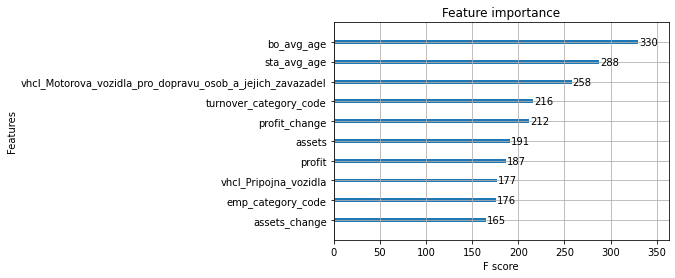

In [19]:
xgb.plot_importance(moto_model, max_num_features=10, importance_type='weight')

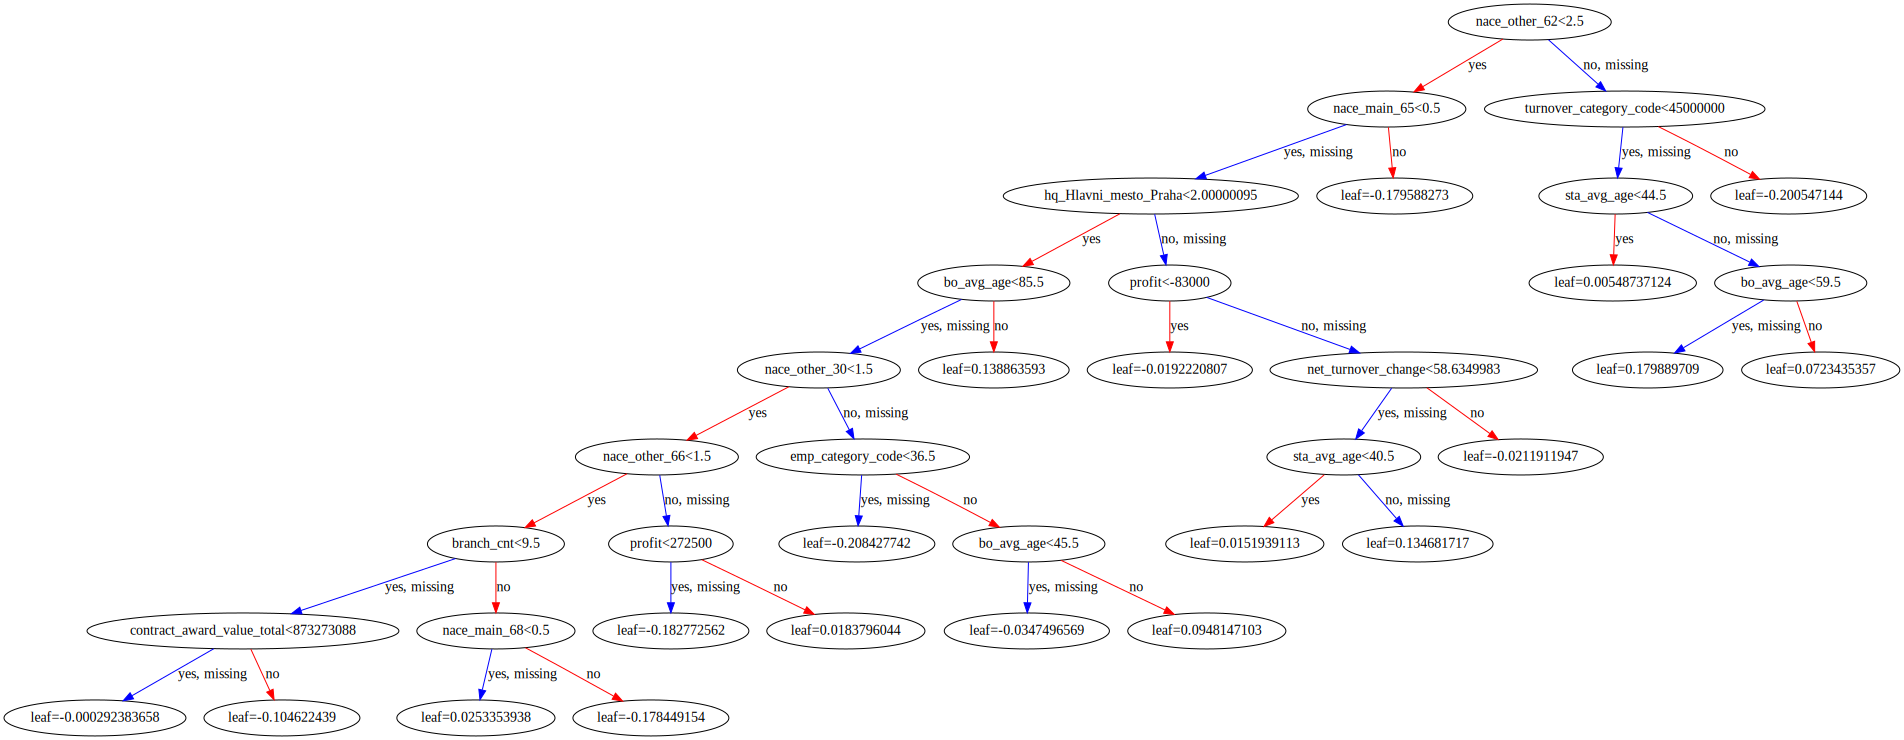

In [21]:
xgb.to_graphviz(moto_model,num_trees=99)

In [24]:
import xgboost
import shap

shap.initjs()

explainer = shap.Explainer(model=moto_model)
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


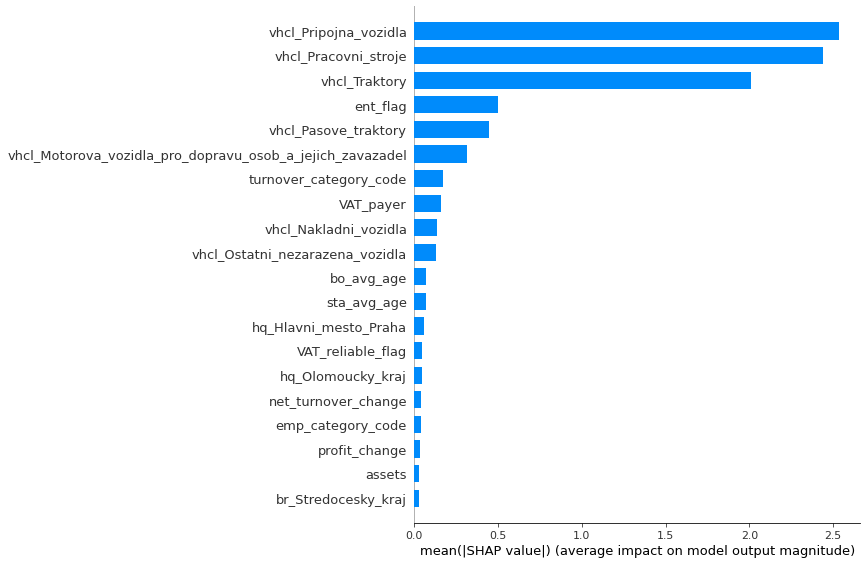

In [25]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [26]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])